In [6]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import seaborn as sns
sns.set_theme(style="white", palette="muted")
sns.set_context("paper", font_scale = 1.3)

import warnings

# Supress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
from matplotlib.patches import Patch, Circle

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

from scipy import stats
from scipy import spatial
import pandas as pd
import numpy as np

from sklearn.covariance import MinCovDet, EmpiricalCovariance
from statsmodels.stats.multitest import fdrcorrection

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.config import get_interim_dir
from src.visualization import defaults

In [8]:
rename_mutations = {
    "Any Insertion": "Ins",
    "Deletion 0bp microhomology": "NoMHDel",
    "Deletion 1bp microhomology": "1bpMHDel",
    "Deletion 2bp microhomology": "2bpMHDel",
    "Deletion 3+bp microhomology": "3+bpMHDel",
    "Deletion with insertion": "Delins",
    "Homology directed repair": "HDR" 
}

In [9]:
alias = "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"

print(get_interim_dir())

X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))

idx = X.index.to_frame().reset_index(drop=True)
idx.loc[idx["Gene"] == "Non", "Gene"] = idx.loc[idx["Gene"] == "Non", "Barcode"]

X.index = pd.MultiIndex.from_frame(idx)

# adamson dataset has multiple "transcripts" for some genes. Remove the duplicates, as I am not sure what impact these "transcripts" have or if its a good idea to aggregate them together
transcripts = {}
for i, r in X.reset_index()[["Gene", "Transcript"]].iterrows():
    if r["Gene"] not in transcripts:
        transcripts[r["Gene"]] = r["Transcript"]

X = X.loc[X.reset_index().apply(lambda x: x["Transcript"] == transcripts[x["Gene"]], axis=1).to_list(), :].droplevel(3)

X = X.loc[:, (X != 0).any(axis=0)]
print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

counts = X.sum(axis=1)

X_orig = X.copy()

X = X.div(X.sum(axis=1), axis=0)
columns = X.columns
X = X.groupby(["Gene"]).mean()
X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)

X = X.rename(columns=rename_mutations)

/Users/colm/repos/MUSICian_v2/musician/data/interim/
0.9993145990404386


In [10]:
X = impute_zero_values(X, 1)

0.00 of our data is zero


In [11]:
X = X[X.columns.sort_values()]

In [12]:
Xt = X[~X.index.str.contains("non-")].copy()
Xnt = X[X.index.str.contains("non-")].copy()

In [13]:
Xnt.shape

(60, 7)

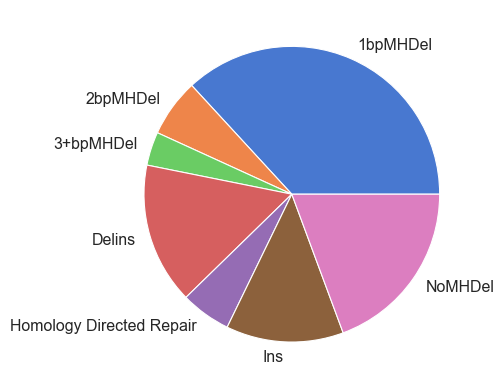

In [14]:
plt.figure()
Xnt.iloc[0, :].plot.pie()
plt.ylabel(None)
plt.show()

In [15]:
Xnt.iloc[0, :]

lumc_category
1bpMHDel                    0.368427
2bpMHDel                    0.063319
3+bpMHDel                   0.036677
Delins                      0.154538
Homology Directed Repair    0.055027
Ins                         0.128470
NoMHDel                     0.193544
Name: non-targeting_00026, dtype: float64

In [16]:
Xt.loc["Xrcc5"]

lumc_category
1bpMHDel                    0.298442
2bpMHDel                    0.050420
3+bpMHDel                   0.042809
Delins                      0.162816
Homology Directed Repair    0.059693
Ins                         0.207723
NoMHDel                     0.178096
Name: Xrcc5, dtype: float64

Text(0, 0.5, '')

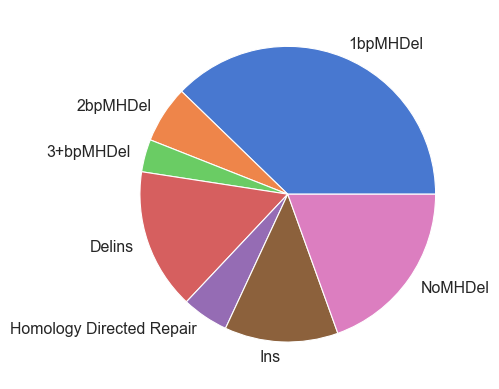

In [17]:
plt.figure()
Xt.loc["Xrcc4"].plot.pie()
plt.ylabel(None)

Text(0, 0.5, '')

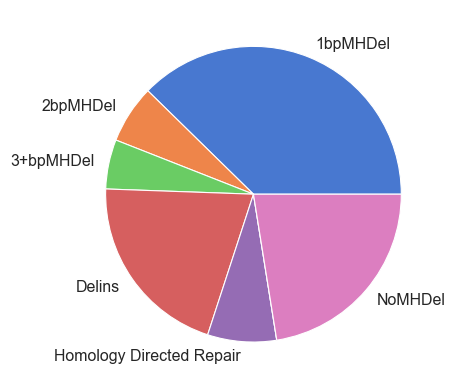

In [18]:
plt.figure()
fake_example = Xt.loc["Xrcc5"].copy()
fake_example["Ins"] = 0
fake_example.plot.pie()
plt.ylabel(None)

Text(0, 0.5, '')

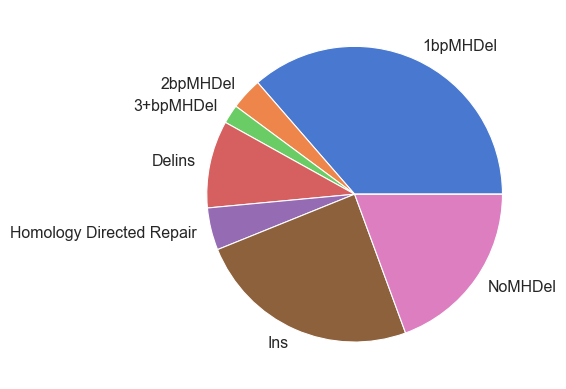

In [19]:
plt.figure()
fake_example = Xt.loc["Mre11a"].copy()
fake_example["HDR"] = 0
fake_example.plot.pie()
plt.ylabel(None)


[0.36978509 0.06192976 0.03746559 0.15124462 0.04651526 0.13456873
 0.19849094]
[0.3695149  0.06116761 0.03647802 0.15677826 0.04996965 0.12930061
 0.19679094]
[0.3719457  0.06190737 0.03730403 0.15062447 0.0443996  0.13430297
 0.19951587]
[0.36958763 0.06116168 0.03644525 0.15682248 0.04987527 0.12928446
 0.19682323]


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/790765856.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


Min 0.0038498139625897563


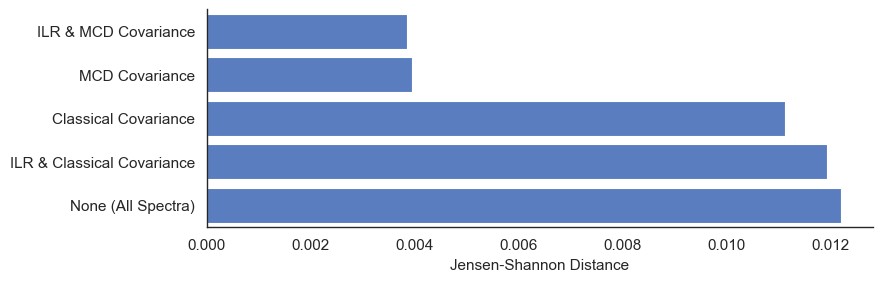

In [20]:
from skbio.stats.composition import ilr_inv, ilr
pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
    outlier_detection(Xt, EmpiricalCovariance())
pca_central_freq = ss.inverse_transform(cov.location_[np.newaxis,:])[0]
print(pca_central_freq)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
        outlier_detection(Xt, MinCovDet(random_state=0))
    robust_pca_central_freq = ss.inverse_transform(cov.location_[np.newaxis,:])[0]
    print(robust_pca_central_freq)


pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(Xt, EmpiricalCovariance())
ilr_pca_central_freq = ilr_inv(cov.location_[np.newaxis,:])
print(ilr_pca_central_freq)

pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(Xt, MinCovDet(random_state=0))
ilr_robust_central_freq = ilr_inv(cov.location_[np.newaxis,:])
print(ilr_robust_central_freq)

from scipy.spatial.distance import cdist

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(Xt), index=Xnt.columns)
gmean_mahal_only = pd.Series(pca_central_freq, index=Xnt.columns)
gmean_robust = pd.Series(robust_pca_central_freq, index=Xnt.columns)
gmean_ilr_mahal = pd.Series(ilr_pca_central_freq, index=Xnt.columns)
gmean_psuedo = pd.Series(ilr_robust_central_freq, index=Xnt.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    "None (All Spectra)",
    "Classical Covariance",
    "MCD Covariance",
    "ILR & Classical Covariance",
    "ILR & MCD Covariance",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
jsds = pd.concat([compare_df, distance_series], axis=1)
jsds = jsds.sort_values("Distance")


def plot_jsds(ax, jsds, fontsize=11):
    sns.barplot(ax=ax, data=jsds["Distance"].reset_index(), x="Distance", y="index", color=sns.color_palette()[0])
    ax.set_ylabel(None)
    ax.set_xlabel("Jensen-Shannon Distance", fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    print("Min",  np.min(jsds["Distance"]))


fig, ax = plt.subplots(figsize=(9, 3))
plot_jsds(ax, jsds)
plt.tight_layout()
plt.show()

Comparing distances for non-targeting samples 60
Min 0.0037293382268192136


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/790765856.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


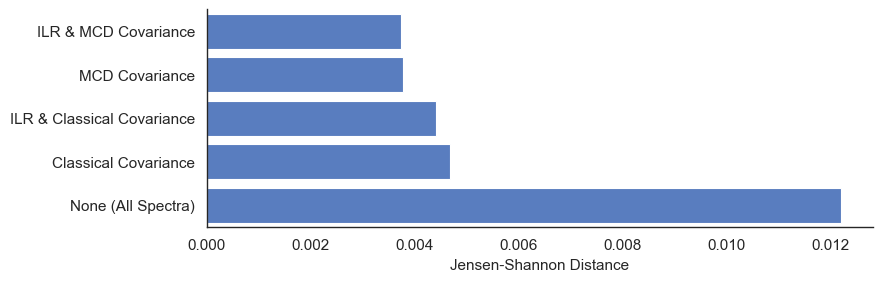

In [21]:
from skbio.stats.composition import ilr_inv, ilr
pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
    outlier_detection(Xt, EmpiricalCovariance())
g1 = pd.Series(distances, index=Xt.index).sort_values()[:100].index

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
        outlier_detection(Xt, MinCovDet(random_state=0))
    g2 = pd.Series(distances, index=Xt.index).sort_values()[:100].index


pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(Xt, EmpiricalCovariance())
g3 = pd.Series(distances, index=Xt.index).sort_values()[:100].index

pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(Xt, MinCovDet(random_state=0))
g4 = pd.Series(distances, index=Xt.index).sort_values()[:100].index

from scipy.spatial.distance import cdist

print("Comparing distances for non-targeting samples", Xnt.shape[0])

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(Xt), index=Xt.columns)
gmean_mahal_only = pd.Series(stats.mstats.gmean(Xt.loc[g1]), index=Xnt.columns)
gmean_robust = pd.Series(stats.mstats.gmean(Xt.loc[g2]), index=Xnt.columns)
gmean_ilr_mahal = pd.Series(stats.mstats.gmean(Xt.loc[g3]), index=Xnt.columns)
gmean_psuedo = pd.Series(stats.mstats.gmean(Xt.loc[g4]), index=Xnt.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    # "None (All Spectra)",
    # "Classical",
    # "Robust",
    # "ILR-Classical",
    # "ILR-Robust",
    "None (All Spectra)",
    "Classical Covariance",
    "MCD Covariance",
    "ILR & Classical Covariance",
    "ILR & MCD Covariance",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
jsds_psuedo_controls = pd.concat([compare_df, distance_series], axis=1)
jsds_psuedo_controls = jsds_psuedo_controls.sort_values("Distance")


fig, ax = plt.subplots(figsize=(9, 3))
plot_jsds(ax, jsds_psuedo_controls)
plt.tight_layout()
plt.show()

In [22]:
jsds_psuedo_controls


,1bpMHDel,2bpMHDel,3+bpMHDel,Delins,Homology Directed Repair,Ins,NoMHDel,Distance
ILR & MCD Covariance,0.369937,0.061266,0.036454,0.156724,0.049868,0.129130,0.196407,0.003729
MCD Covariance,0.369942,0.061260,0.036461,0.156658,0.049786,0.129213,0.196460,0.003772
ILR & Classical Covariance,0.369780,0.061262,0.036705,0.156343,0.048917,0.129971,0.196722,0.004415
Classical Covariance,0.369889,0.061461,0.036810,0.155839,0.049124,0.130000,0.196599,0.004685
None (All Spectra),0.369160,0.061444,0.037025,0.149496,0.044067,0.133297,0.198021,0.012197


In [23]:
Xt.loc[Xt.index.str.contains("non-targeting")].shape

(0, 7)

In [24]:
X = X.rename(columns= {
    "1bpMHDel": "Deletion 1bp microhomology",
    "2bpMHDel": "Deletion 2bp microhomology",
    "3+bpMHDel": "Deletion 3+bp microhomology",
    "Delins": "Deletion with insertion",
    "HDR": "Homology directed repair",
    "Ins": "Any insertion",
    "NoMHDel": "Deletion with no microhomology",
}).sort_index(axis=1)

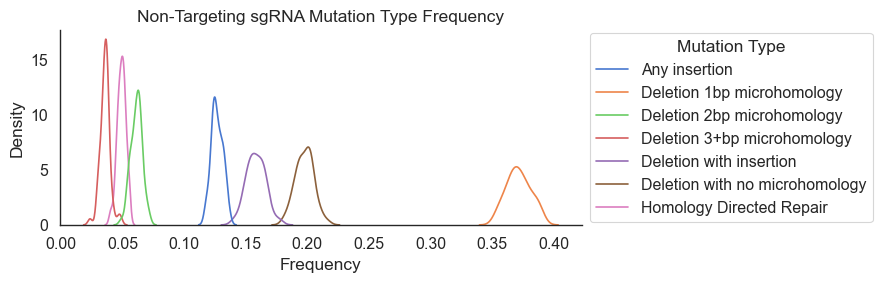

In [25]:
plt.figure(figsize=(9, 3))
ax = sns.kdeplot(data = X.loc[X.index.str.contains("non-targeting")].stack().reset_index().rename(columns={"lumc_category": "Mutation Type", 0: "Frequency"}), \
            x = "Frequency", hue="Mutation Type")
plt.title("Non-Targeting sgRNA Mutation Type Frequency")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("artifacts/mutation_type_kdeplot.pdf", bbox_inches='tight')


In [26]:
np.corrcoef(ilr(Xt).T).shape

(6, 6)

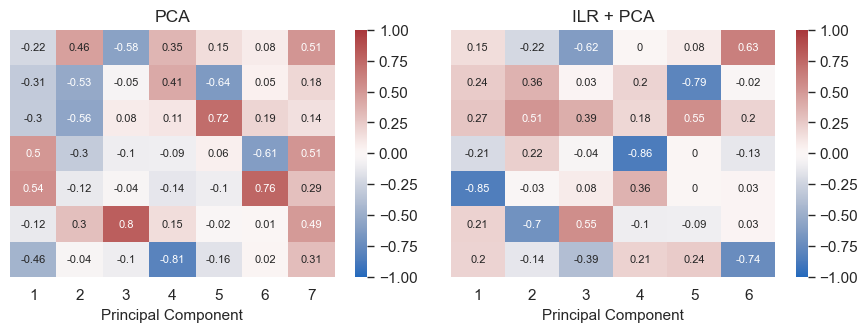

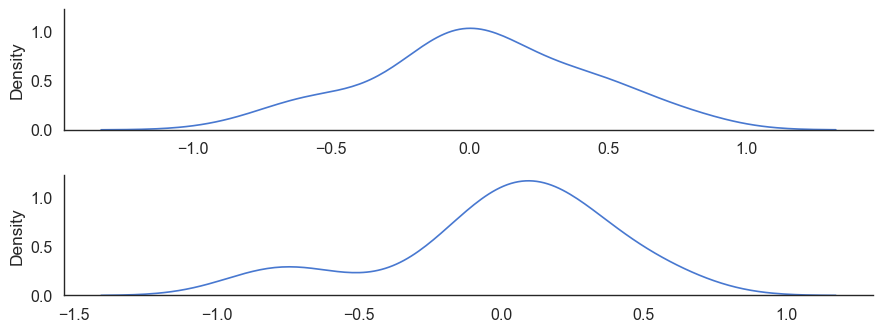

In [27]:
def heatmap(ax, X, cov, outlier_detection, annot=True, fontsize=11):
    results = outlier_detection(X, cov)
    score, coeff = results[:2]
    num_pc = coeff.shape[1]
    pc_list = [str(i) for i in list(range(1, num_pc+1))]
    loadings_df = pd.DataFrame(coeff, columns=pc_list, index=X.columns)

    g = sns.heatmap(loadings_df.round(2), annot=annot, cmap='vlag', ax = ax, annot_kws={"fontsize": 8}, center=0, vmin=-1, vmax=1)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fontsize)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize)
    ax.set_xlabel("Principal Component", fontsize=fontsize)
    ax.set_ylabel(None)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    return results



fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True, sharex=False)

r1 = heatmap(ax[0], Xt, EmpiricalCovariance(), outlier_detection)
ax[0].set_title("PCA")
r2 = heatmap(ax[1], Xt, EmpiricalCovariance(), logratio_outlier_detection)
ax[1].set_title("ILR + PCA")

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(2, 1, figsize=(9, 3.5), sharey=True, sharex=False)
l1 = r1[1]
l2 = r2[1]
sns.kdeplot(np.ndarray.flatten(l1), ax=ax[0])
sns.kdeplot(np.ndarray.flatten(l2), ax=ax[1])

plt.tight_layout()
plt.show()


In [28]:
Xt

lumc_category,1bpMHDel,2bpMHDel,3+bpMHDel,Delins,Homology Directed Repair,Ins,NoMHDel
Gene,,,,,,,
Actl6a,0.370329,0.056800,0.035505,0.146207,0.041412,0.161979,0.187768
Actr5,0.370320,0.048522,0.032552,0.160077,0.047616,0.144957,0.195956
Actr8,0.374125,0.055238,0.030130,0.152400,0.053197,0.131315,0.203595
Aicda,0.369058,0.063038,0.035013,0.159269,0.051447,0.127185,0.194990
Alkbh2,0.370139,0.063219,0.036366,0.155689,0.054724,0.126305,0.193559
...,...,...,...,...,...,...,...
Ybx3,0.376770,0.060779,0.039714,0.149534,0.043018,0.127998,0.202187
Yeats4,0.361320,0.061874,0.039233,0.152926,0.046997,0.138727,0.198924
Yy1,0.373971,0.062552,0.036103,0.155272,0.049001,0.122622,0.200478


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/2910148821.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/2910148821.py:58: UserWarning: FixedFormatter should only be used together with FixedLo

Classical Covariance
(60, 7)
Euclidean Distance: 0.449020
MCD Covariance
(60, 7)
Euclidean Distance: 0.430537
ILR & Classical Covariance
(60, 7)
Euclidean Distance: 0.124083
ILR & MCD Covariance


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/2910148821.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/2910148821.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you

(60, 7)
Euclidean Distance: 0.001445
Min 0.0037293382268192136


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/790765856.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


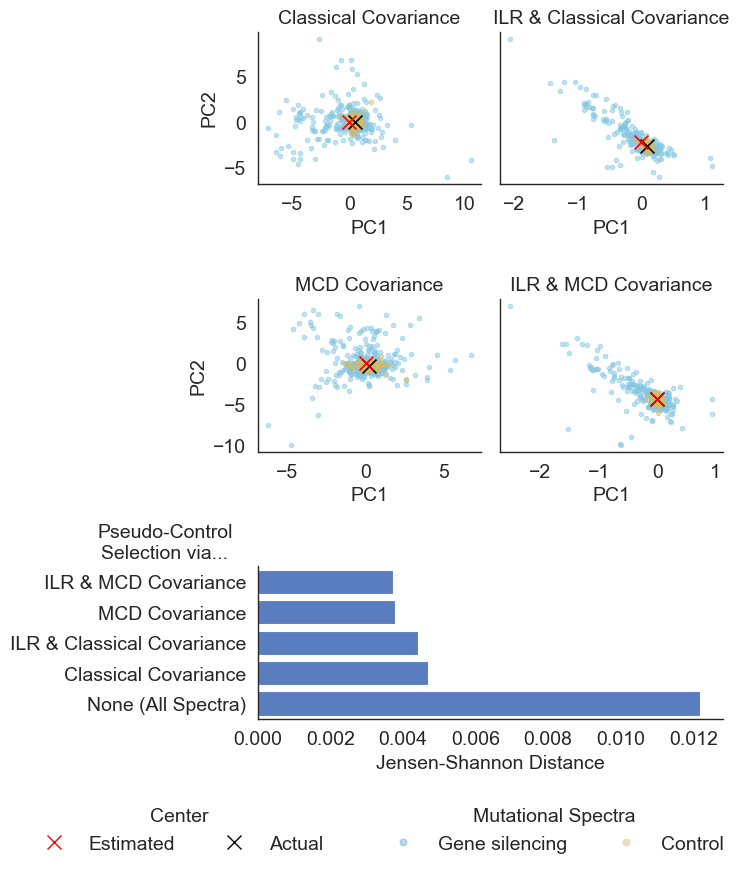

In [29]:
from scipy.stats import multivariate_normal

# Create a biplot
def biplot(ax, X, cov, outlier_detection):
    X_nt = X[X.index.str.contains("non-")]
    X_t = X[~X.index.str.contains("non-")]

    results = outlier_detection(X_t, cov, transform_data=X_nt)


    score, coeff = results[:2]
    covariance_ = results[-1].covariance_
    labels = X.columns

    score_nt = results[5]#[X.index.str.contains("non-")]
    # score_t = score[~X.index.str.contains("non-")]
    score_t = results[0]

    print(score_nt.shape)

    # Get Seaborn color palette
    colors = sns.color_palette()

    # plot spectra
    ax.scatter(score_t[:, 0], score_t[:, 1], alpha=0.5, c=colors[9], s=10)
    ax.scatter(score_nt[:, 0], score_nt[:, 1], alpha=0.5, c=colors[8], s=10)


    # plot arrows
    # for i in range(len(coeff)):
    #     scaling_factor = score.max().max()
    #     ax.arrow(0, 0, coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor,\
    #             color=colors[7], linewidth=1, head_width=scaling_factor*0.05, alpha=0.5)
        # ax.text(coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor, labels[i], color=colors[7],
                # ha='center', va='top') 
    
    # plot centers
    ax.scatter(score_nt[:, 0].mean(), score_nt[:, 1].mean(), marker='x', color='black', s=100)  
    ax.scatter(0, 0, marker='x', color='red', s=100)  

    a = np.array((0, 0))
    b = np.array((score_nt[:, 0].mean(), score_nt[:, 1].mean()))
    print("Euclidean Distance: {:3f}".format(np.linalg.norm(a - b)))

    # plot contours
    # pc1absmax = np.max(np.abs(score_t[:,0]))
    # pc2absmax = np.max(np.abs(score_t[:,1]))
    # x, y = np.mgrid[-pc1absmax:pc1absmax:.01, -pc2absmax:pc2absmax:.01]
    # rv = multivariate_normal([0, 0], [covariance_[0,[0,1]], covariance_[0,[0,1]][::-1]])
    # data = np.dstack((x, y))
    # z = rv.pdf(data)
    # ax.contour(x, y, z)

    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


fig = plt.figure(figsize=(7.5, 8))

# AX = mpl.gridspec.GridSpec(5, 2, height_ratios=[4, 1, 3, 3, 4.5])
AX = mpl.gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# ax00 = plt.subplot(AX[0, 0])
# ax01 = plt.subplot(AX[0, 1])
# ax10 = plt.subplot(AX[1, 0])
# ax11 = plt.subplot(AX[1, 1])
ax1 = plt.subplot(AX[0, 0])
ax2 = plt.subplot(AX[0, 1])
ax3 = plt.subplot(AX[1, 0])
ax4 = plt.subplot(AX[1, 1])
ax5 = plt.subplot(AX[2, :])

# r1 = heatmap(ax00, Xt, EmpiricalCovariance(), outlier_detection, annot=False, fontsize=14)
# r2 = heatmap(ax01, Xt, MinCovDet(random_state=0), logratio_outlier_detection, annot=False, fontsize=14)


# # KDE plot
# l1 = r1[1]
# l2 = r2[1]
# kde1 = sns.kdeplot(np.ndarray.flatten(pd.DataFrame(l1).mul(r1[2], axis=1).values), ax=ax10)
# ax10.set_xticklabels(ax10.get_xticklabels(), fontsize=14)
# ax10.set_yticklabels(ax10.get_yticklabels(), fontsize=14)
# ax10.set_ylabel(ax10.get_ylabel(), fontsize=14)
# kde2 = sns.kdeplot(np.ndarray.flatten(pd.DataFrame(l2).mul(r2[2], axis=1).values), ax=ax11)
# ax11.set_xticklabels(ax11.get_xticklabels(), fontsize=14)
# ax11.set_yticklabels(ax11.get_yticklabels(), fontsize=14)
# ax11.set_ylabel(ax10.get_ylabel(), fontsize=14)

# PCA
print("Classical Covariance")
biplot(ax1, X, EmpiricalCovariance(), outlier_detection)
print("MCD Covariance")
biplot(ax3, X, MinCovDet(random_state=0), outlier_detection)
print("ILR & Classical Covariance")
biplot(ax2, X, EmpiricalCovariance(), logratio_outlier_detection)
print("ILR & MCD Covariance")
biplot(ax4, X, MinCovDet(random_state=0), logratio_outlier_detection)

# JSDs
plot_jsds(ax5, jsds_psuedo_controls, fontsize=14)


ax1.set_title("Classical Covariance", fontsize=14)
ax2.set_title("ILR & Classical Covariance", fontsize=14)
ax3.set_title("MCD Covariance", fontsize=14)
ax4.set_title("ILR & MCD Covariance", fontsize=14)

# ax00.text(-0.44, 1.1, "A", transform=ax00.transAxes, 
#             size=16, weight='bold')
# ax10.text(-0.34, 1.1, "B", transform=ax10.transAxes, 
#             size=16, weight='bold')
# ax1.text(-0.34, 1.1, "A", transform=ax1.transAxes, 
#             size=16, weight='bold')
# ax5.text(-0.17, 1.1, "B", transform=ax5.transAxes, 
#             size=16, weight='bold')

# labels
# ax00.set_ylabel("Mutation Type\n", fontsize=14)
# ax00.set_xlabel(None)
# ax01.set_xlabel(None)
# ax01.set_ylabel(None)
# ax11.set_ylabel(None)

# for axi in [ax01, ax11, ax2, ax4]:
for axi in [ax2, ax4]:
    plt.setp(axi.get_yticklabels(), visible=False)
    axi.set_ylabel(None)

from matplotlib.lines import Line2D
colors = sns.color_palette()

legend_labels2 = ["Gene silencing", "Control"]
legend_handles2 = [Line2D([0], [0], marker='o', linewidth=0, color=colors[i+8][::-1], alpha=0.5) for i in range(2)]
lgd2 = fig.legend(legend_handles2, legend_labels2, loc='lower center', ncol=2, title='Mutational Spectra', fontsize=14, frameon=False,\
            bbox_to_anchor=(0.75, -0.1))

legend_labels1 = ["Estimated", "Actual"]
legend_handles1 = [Line2D([0], [0], marker='x', linewidth=0, color=c, markersize=10) for c in ["red", "black"]]
lgd1 = fig.legend(legend_handles1, legend_labels1, loc='lower center', ncol=2, title='Center', fontsize=14, frameon=False,\
            bbox_to_anchor=(0.25, -0.1))

plt.setp(lgd1.get_title(),fontsize=14)
plt.setp(lgd2.get_title(),fontsize=14)

t5 = ax5.set_title("Pseudo-Control\nSelection via...", fontsize=14, x=-0.2)

plt.tight_layout()
plt.savefig("artifacts/repair-seq-pca.svg", bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')


In [30]:
np.ndarray.flatten(l1)

array([-0.22173992,  0.4551363 , -0.5771628 ,  0.34897697,  0.14680656,
        0.08439952,  0.51000498, -0.30555512, -0.53404269, -0.04985422,
        0.40858521, -0.64435321,  0.05268187,  0.18450128, -0.30215335,
       -0.55677091,  0.07802491,  0.11040383,  0.72397857,  0.19305217,
        0.13790758,  0.50137449, -0.30370344, -0.10298907, -0.08695623,
        0.06427296, -0.60810373,  0.51409974,  0.53504404, -0.11609577,
       -0.03873953, -0.14347776, -0.09923259,  0.76326377,  0.29282133,
       -0.11817655,  0.30031574,  0.79744708,  0.14665407, -0.02135992,
        0.00665786,  0.48776524, -0.46320258, -0.04185642, -0.10139243,
       -0.8058719 , -0.15709055,  0.02064305,  0.31444854])

In [31]:
pd.DataFrame(l1)

,0,1,2,3,4,5,6
0,-0.221740,0.455136,-0.577163,0.348977,0.146807,0.084400,0.510005
1,-0.305555,-0.534043,-0.049854,0.408585,-0.644353,0.052682,0.184501
2,-0.302153,-0.556771,0.078025,0.110404,0.723979,0.193052,0.137908
3,0.501374,-0.303703,-0.102989,-0.086956,0.064273,-0.608104,0.514100
4,0.535044,-0.116096,-0.038740,-0.143478,-0.099233,0.763264,0.292821
5,-0.118177,0.300316,0.797447,0.146654,-0.021360,0.006658,0.487765
6,-0.463203,-0.041856,-0.101392,-0.805872,-0.157091,0.020643,0.314449


<AxesSubplot: ylabel='Density'>

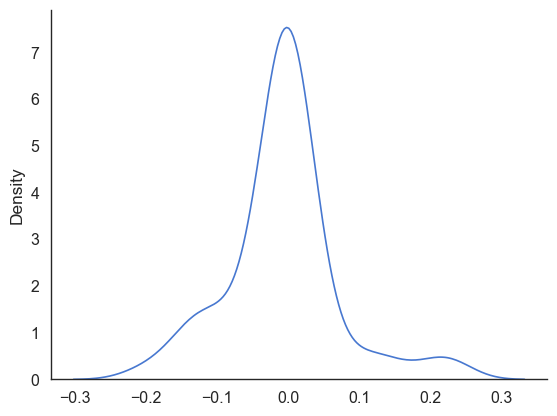

In [32]:
sns.kdeplot(np.ndarray.flatten(pd.DataFrame(l1).mul(r1[2], axis=1).values))

<AxesSubplot: ylabel='Density'>

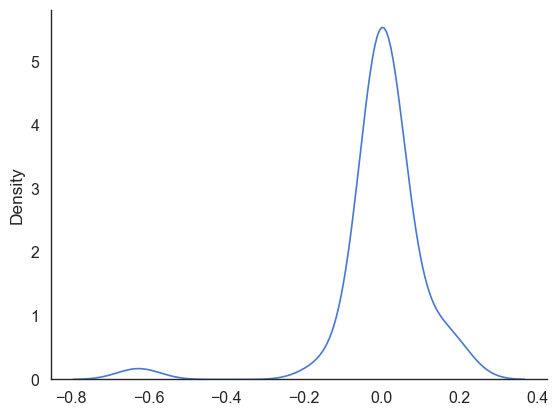

In [33]:
sns.kdeplot(np.ndarray.flatten(pd.DataFrame(l2).mul(r2[2], axis=1).values))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


PCA
Robust PCA


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.791213333490589 > -54.342724060261688). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.224633545951875 > -55.481640856172604). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust

ILR + PCA
ILR + Robust PCA


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66329/790765856.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


Min 0.0037293382268192136


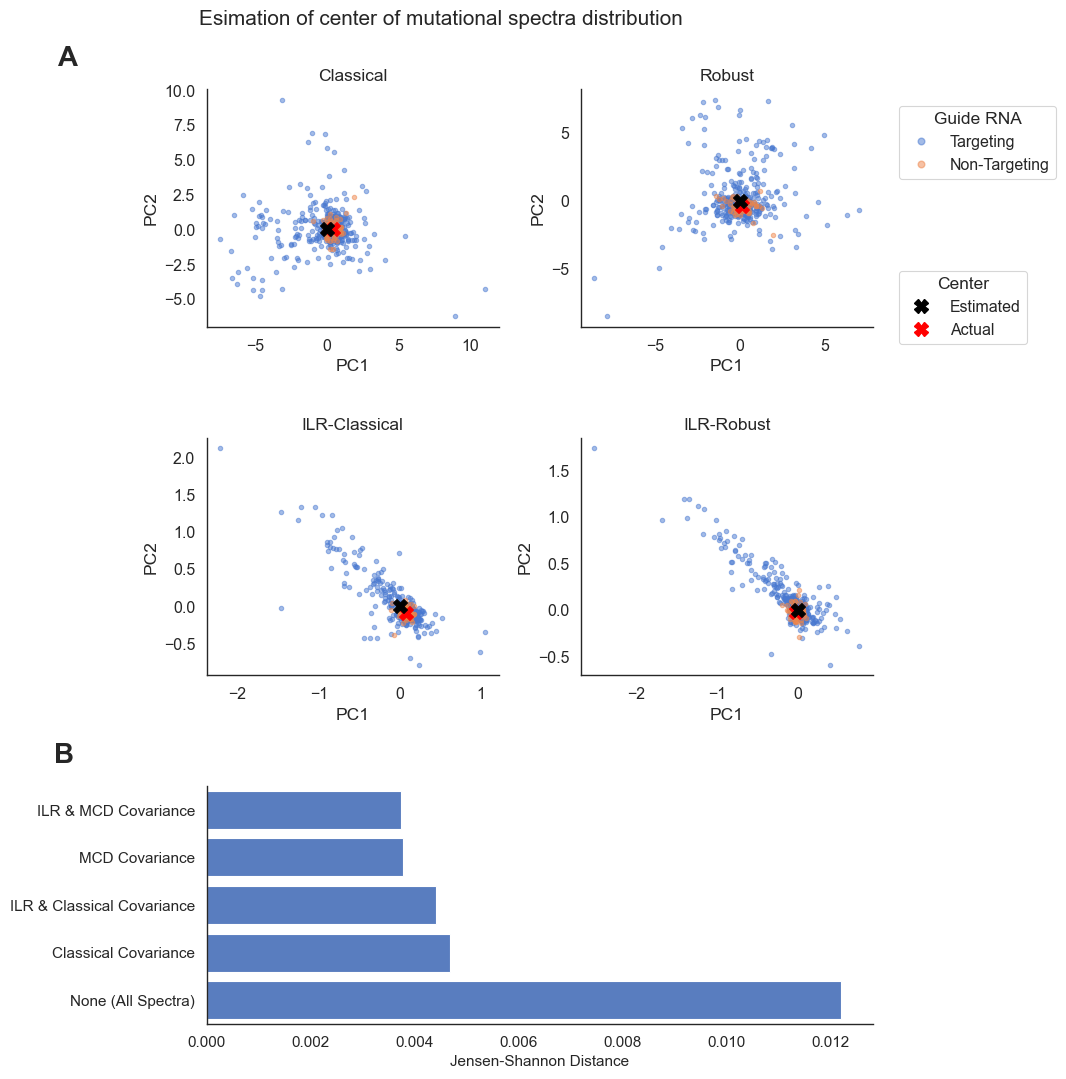

In [34]:
from scipy.stats import multivariate_normal

# Create a biplot
def biplot(ax, X, cov, outlier_detection):
    results = outlier_detection(X, cov)
    score, coeff = results[:2]
    covariance_ = results[-1].covariance_
    labels = X.columns

    score_nt = score[X.index.str.contains("non-")]
    score_t = score[~X.index.str.contains("non-")]

    # Get Seaborn color palette
    colors = sns.color_palette()

    # plot spectra
    ax.scatter(score_t[:, 0], score_t[:, 1], alpha=0.5, c=colors[0], s=10)
    ax.scatter(score_nt[:, 0], score_nt[:, 1], alpha=0.5, c=colors[1], s=10)


    # plot arrows
    # for i in range(len(coeff)):
    #     scaling_factor = score.max().max()
    #     ax.arrow(0, 0, coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor,\
    #             color=colors[7], linewidth=1, head_width=scaling_factor*0.05, alpha=0.5)
        # ax.text(coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor, labels[i], color=colors[7],
        #         ha='center', va='top') 
    
    # plot centers
    ax.scatter(score_nt[:, 0].mean(), score_nt[:, 1].mean(), marker='X', color='red', s=100)  
    ax.scatter(0, 0, marker='X', color='black', s=100)  

    # plot contours
    # pc1absmax = np.max(np.abs(score_t[:,0]))
    # pc2absmax = np.max(np.abs(score_t[:,1]))
    # x, y = np.mgrid[-pc1absmax:pc1absmax:.01, -pc2absmax:pc2absmax:.01]
    # rv = multivariate_normal([0, 0], [covariance_[0,[0,1]], covariance_[0,[0,1]][::-1]])
    # data = np.dstack((x, y))
    # z = rv.pdf(data)
    # ax.contour(x, y, z)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")


fig = plt.figure(figsize=(9, 11))

# ax0 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# g = sns.kdeplot(data=Xnt.stack()\
#     .reset_index()\
#     .rename(columns={"Gene": "", "lumc_category": "Mutation Type", 0: "Frequency"}), 
#     x="Frequency", hue="Mutation Type", common_norm=True, ax=ax0, legend=False)

print("PCA")
biplot(ax1, X, EmpiricalCovariance(), outlier_detection)
print("Robust PCA")
biplot(ax2, X, MinCovDet(random_state=0), outlier_detection)
print("ILR + PCA")
biplot(ax3, X, EmpiricalCovariance(), logratio_outlier_detection)
print("ILR + Robust PCA")
biplot(ax4, X, MinCovDet(random_state=0), logratio_outlier_detection)
# JSDs
plot_jsds(ax5, jsds_psuedo_controls)

#titles
ax1.set_title("Classical")
ax2.set_title("Robust")
ax3.set_title("ILR-Classical")
ax4.set_title("ILR-Robust")

# ax1.text(-0.23, 1.1, "A", transform=ax0.transAxes, 
#             size=20, weight='bold')

ax1.text(-0.51, 1.1, "A", transform=ax1.transAxes, 
            size=20, weight='bold')
ax5.text(-0.23, 1.1, "B", transform=ax5.transAxes, 
            size=20, weight='bold')

# labels
# ax[0, 0].set_xlabel(None)
# ax[0, 1].set_xlabel(None)
# ax[0, 1].set_ylabel(None)
# ax[1, 1].set_ylabel(None)

from matplotlib.lines import Line2D
colors = sns.color_palette()

legend_labels2 = ["Targeting", "Non-Targeting"]
legend_handles2 = [Line2D([0], [0], marker='o', linewidth=0, color=colors[i], alpha=0.5) for i in range(2)]
lgd2 = fig.legend(legend_handles2, legend_labels2, loc='upper left', ncol=1, title='Guide RNA',\
            bbox_to_anchor=(1, 0.9))

legend_labels1 = ["Estimated", "Actual"]
legend_handles1 = [Line2D([0], [0], marker='X', linewidth=0, color=c, markersize=10) for c in ["black", "red"]]
lgd1 = fig.legend(legend_handles1, legend_labels1, loc='upper left', ncol=1, title='Center',\
            bbox_to_anchor=(1, 0.75))

# plt.text(0.02, 0.9, "A", transform=fig.transFigure, 
#             size=20, weight='bold')
# # plt.text(0.02, 0.35, "B", transform=fig.transFigure, 
# #             size=20, weight='bold')

title1 = plt.suptitle("Esimation of center of mutational spectra distribution")
plt.tight_layout()
plt.savefig("artifacts/estimation_of_center.pdf", bbox_extra_artists=(lgd1,lgd2, title1), bbox_inches='tight')

In [35]:
from scipy.stats import shapiro
import skbio

X0 = X[X.index.str.contains("non-")]

for c in X0.columns:
    stat, p_value = shapiro(X0[c])
    print(f'Feature: {c}, Statistic: {stat}, p-value: {p_value}')

X1 = pd.DataFrame(skbio.stats.composition.ilr(X), index=X.index)
X1 = X1[X1.index.str.contains("non-")]
for c in X1.columns:
    stat, p_value = shapiro(X1[c])
    print(f'Feature: {c}, Statistic: {stat}, p-value: {p_value}')



Feature: Any insertion, Statistic: 0.9784324169158936, p-value: 0.36589300632476807
Feature: Deletion 1bp microhomology, Statistic: 0.980850338935852, p-value: 0.4655531942844391
Feature: Deletion 2bp microhomology, Statistic: 0.9866563677787781, p-value: 0.7555930614471436
Feature: Deletion 3+bp microhomology, Statistic: 0.9484768509864807, p-value: 0.01321554183959961
Feature: Deletion with insertion, Statistic: 0.9935280084609985, p-value: 0.9878324866294861
Feature: Deletion with no microhomology, Statistic: 0.9910783171653748, p-value: 0.9406067132949829
Feature: Homology Directed Repair, Statistic: 0.9808912873268127, p-value: 0.4673859179019928
Feature: 0, Statistic: 0.987069308757782, p-value: 0.7763585448265076
Feature: 1, Statistic: 0.9656631350517273, p-value: 0.08929577469825745
Feature: 2, Statistic: 0.951287031173706, p-value: 0.017911594361066818
Feature: 3, Statistic: 0.9384783506393433, p-value: 0.004632623866200447
Feature: 4, Statistic: 0.9782683253288269, p-value: 0

In [36]:
pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(X, EmpiricalCovariance())
reject = fdrcorrection(pvalues, alpha=0.95)[0]
mahal_only_controls = X[~reject].index.to_list()
X_mahal_only_controls = X[X.index.isin(mahal_only_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(X, MinCovDet(random_state=0))
reject = fdrcorrection(pvalues, alpha=0.95)[0]
robust_controls = X[~reject].index.to_list()
X_robust_controls = X[X.index.isin(robust_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss = logratio_outlier_detection(X, EmpiricalCovariance())
reject = fdrcorrection(pvalues, alpha=0.95)[0]
ilr_mahal_controls = X[~reject].index.to_list()
X_ilr_mahal_controls = X[X.index.isin(ilr_mahal_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss = logratio_outlier_detection(X, MinCovDet(random_state=0))
reject = fdrcorrection(pvalues, alpha=0.95)[0]
psuedo_controls = X[~reject].index.to_list()
X_psuedo_controls = X[X.index.isin(psuedo_controls)].copy()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.791213333490589 > -54.342724060261688). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.224633545951875 > -55.481640856172604). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust

In [37]:
from scipy.spatial.distance import cdist

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(X), index=X.columns)
gmean_mahal_only = pd.Series(stats.mstats.gmean(X_mahal_only_controls), index=X_mahal_only_controls.columns)
gmean_robust = pd.Series(stats.mstats.gmean(X_robust_controls), index=X_robust_controls.columns)
gmean_ilr_mahal = pd.Series(stats.mstats.gmean(X_ilr_mahal_controls), index=X_ilr_mahal_controls.columns)
gmean_psuedo = pd.Series(stats.mstats.gmean(X_psuedo_controls), index=X_psuedo_controls.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    "Geomean",
    "Mahalanobis",
    "Robust",
    "ILR + Mahalanobis",
    "ILR + Robust",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
result_df = pd.concat([compare_df, distance_series], axis=1)
result_df.sort_values("Distance")

,Any insertion,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion 3+bp microhomology,Deletion with insertion,Deletion with no microhomology,Homology Directed Repair,Distance
Geomean,0.132515,0.369426,0.061385,0.036844,0.150438,0.197973,0.044593,0.454360
Robust,0.129248,0.369809,0.061336,0.036421,0.156458,0.196831,0.049630,0.455996
ILR + Mahalanobis,0.129623,0.369994,0.061204,0.036434,0.155256,0.197299,0.048706,0.456003
Mahalanobis,0.129924,0.370388,0.061355,0.036501,0.154123,0.197665,0.047907,0.456157
ILR + Robust,0.128839,0.369756,0.061316,0.036481,0.156924,0.196784,0.049744,0.456228


In [39]:
# bootstrapped_means = pkl.load(open("../exploratory/outlier_analysis/artifacts/jsd_estimates.pkl", "rb"))

# jensha_dis = bootstrapped_means["bootstrapped"]
# pjsd = bootstrapped_means["pseudo"]
# jsd = bootstrapped_means["actual"]

# plt.figure(figsize=(9, 2.8))

# sns.histplot(jensha_dis)
# plt.axvline(pjsd, c=sns.color_palette()[1])
# # plt.axvline(jsd, c=sns.color_palette()[1])
# plt.ylim(0, 600)
# # plt.annotate("Psuedo-\ncontrol\nprofile", (pjsd + 0.0005, 500), c="red")
# # plt.annotate("Mean profile", (jsd + 0.0005, 570), c="grey")
# plt.title("Estimation of the non-targeting geometric mean mutational spectra")
# plt.xlabel("Jensen-Shannon Distance")
# plt.ylabel("Count")
# custom_lines = [Line2D([0], [0], color=sns.color_palette()[1], lw=2),
#                 Line2D([0], [0], color=sns.color_palette()[0], lw=2)]
# plt.legend(custom_lines, ["Pseudo-controls", "Random controls"], ncols=1, loc="best")
# plt.tight_layout()